# RISCV gem5 Configuration Tests
These tests are with a gem5 configuration which resembles fu540 board

## Specifications of U74 RISC-V Core

- L1 instruction cache
    - L1 is partially inclusive with L2 cache
    - Virtually indexed, physically tagged
    - read/write allocate, random replacement policy
    - Instruction caches are not kept coherent, that is why for self-modifying code, fence instructions might be needed
    - Access latency: 1 clock cycle


- Instruction fetch unit
    - Throughput : 8 bytes of insts/cycle (2 insts per cycle for 32 bit insts)


- Branch prediction
    - 16 entry BTB,  3.6KiB branch history table, 8 entry indirect jump target predictor , 6 entry RAS
    - Mispredicted branches → 4 cycle penalty, mispredicted indirect jumps → 6 cycle penalty

- Pipeline
    - Dual issue, in-order. 8 stages → (F1, F2, D1, D2, AG, M1, M2 and WB)

- Data Cache
    - L1→32KiB, 8 way , virtually indexed-physically tagged, random replacement, write back
    - L1 hit latency : 2 cycles (words, double words), 3 cycles (smaller quantities)
    - Loads to addresses in store pipeline →  5 cycle penalty
    - L1 is inclusive with l2 cache (When a block of data is allocated to the L1 cache, it is also allocated to the L2 cache. When ablock is evicted from the L1, the corresponding line in the L2 is then updated and marked dirty)
    - L2→2MiB, 16 way with 4 banks
    - Only one outstanding cache line fill

- TLB 
    - fully associative 40 entry L1 data and inst. tlbs, 512 entry L2 TLB

In [89]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import os

In [90]:
datadir = '/data/RISCV/'

In [91]:
# function to extract stats
def getStat(filename, stat):
    #filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    try: 
        with open(filename) as f:
            readlines = f.readlines()
            for l in readlines:
                if stat in l:
                    return l
            return 0.0 #for cases where stat was not found
    except: #for cases where the file was not found
        return 0.0

In [25]:
# function to extract stats
def getPerfStat(filename, stat):
    #filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    if stat == 'system.cpu.ipc':
        stat = 'insn per cycle'
    else:
        return 0.0
    
    try: 
        with open(filename) as f:
            readlines = f.readlines()
            for l in readlines:
                if stat in l:
                    return l
            return 0.0 #for cases where stat was not found
    except: #for cases where the file was not found
        return 0.0

In [32]:
Configs = ['real', 'gem5']

CPU = ['minor']

#'execution_int_div_ind',  'execution_fp_add_ind', 
# 'execution_fp_mul_ind', 'execution_fp_div_ind' are currently not included

Benchmarks = ['control_complex', 'control_conditional', 'control_random', 'control_small_bbl', 'control_switch',
                  'dependency_chain1', 'dependency_chain2', 'dependency_chain3', 'dependency_chain4',
                  'execution_int_add_ind', 'execution_int_mul_ind']

Mem_Benchmarks = ['memory_load_dep', 'memory_load_ind', 'memory_load_random', 'memory_store_ind', 
                  'memory_store_random']

Sizes = ['256', '512', '1024', '32768', '65536']

Stats = ['simSeconds', 'hostSeconds', 'system.cpu.ipc', 'system.cpu.mmu.dtb.readAccesses', 'system.cpu.mmu.dtb.writeAccesses', 
         'system.cpu.mmu.dtb.readMisses','system.cpu.mmu.dtb.writeMisses','system.cpu.branchPred.lookups',
         'system.cpu.branchPred.condIncorrect', 'system.cpu.dcache.overallAccesses::total', 
         'system.cpu.dcache.overallMisses::total','system.mem_cntrls.dram.numReads::total',
         'system.mem_cntrls.dram.numWrites::total']

In [33]:
#if pdf v1.5 is not used the hatches in generated figs do not show up on certain pdf viewers
# this function takes care of that issue
def savepdfviasvg(fig, name, **kwargs):
    import subprocess
    fig.savefig(name+".svg", format="svg", **kwargs)
    incmd = ["inkscape", name+".svg", "--export-pdf={}.pdf".format(name),
             "--export-pdf-version=1.5"] #"--export-ignore-filters",
    subprocess.check_output(incmd)

In [34]:
rows = []

for conf in Configs:
    for cpu in CPU:
        for bench in Benchmarks:
            stats = [cpu, bench, conf, 0]
            for stat in Stats:
                if conf == 'gem5':
                    file_path = '{}/{}_u74/{}/stats.txt'.format(datadir,conf,bench)
                    ret_line = getStat(file_path,stat)
                    if ret_line != 0:
                        stat_val = ret_line.split()[1]
                    else:
                        stat_val = 'N/A'
                else:
                    file_path = '{}/{}_u74/{}/perf.txt'.format(datadir,conf,bench)
                    ret_line = getPerfStat(file_path,stat)
                    if ret_line != 0:
                        stat_val = ret_line.split()[3]
                    else:
                        stat_val = 'N/A'
                
                stats.append(stat_val)

            rows.append(stats) 


# for memory benchmarks
            
for conf in Configs:
    for cpu in CPU:
        for bench in Mem_Benchmarks:
            for sz in Sizes:
                stats = [cpu, bench, conf, sz]
                for stat in Stats:
                    if conf == 'gem5':
                        file_path = '{}/{}_u74/{}/{}/stats.txt'.format(datadir,conf,bench,sz)
                        ret_line = getStat(file_path,stat)
                        if ret_line != 0:
                            stat_val = ret_line.split()[1]
                        else:
                            stat_val = 'N/A'
                    else:
                        file_path = '{}/{}_u74/{}/{}/perf.txt'.format(datadir,conf,bench,sz)
                        ret_line = getPerfStat(file_path,stat)
                        if ret_line != 0:
                            stat_val = ret_line.split()[3]
                        else:
                            stat_val = 'N/A'

                    stats.append(stat_val)

                rows.append(stats)             
            

df = pd.DataFrame(rows, columns=['cpu','benchmark','conf', 'size', 'time','host_time', 'ipc', 'dtbReads', 'dtbWrites', 
                                 'dtbReadMisses','dtbWriteMisses','bPredLookUps','bPredIncorrect',
                                 'dcacheAccesses','dcacheMisses','dramReads','dramWrites'])

In [82]:
#print(df[(df['benchmark']=='memory_load_dep')])

In [65]:
def doplot_stat(stat, size, norm=False):   
    i = 0
    
    if size == 0:
        bench_2_use = Benchmarks
    else:
        bench_2_use = Mem_Benchmarks
    
    
    for b, bench in enumerate(bench_2_use):
        for j,conf in enumerate(Configs):
            #print(bench)    
            d = df[(df['benchmark']==bench) & (df['conf']==conf) & (df['size']==size)]
            
            #print(d)
            
            to_norm = 1
            #if conf == 'real':
            #    to_norm = float(d[stat].iloc[0])
            
            if norm == True:
                plt.bar(i, float(d[stat].iloc[0])/to_norm, color='C'+str(j))
                if sec == 'gem5':
                    print(float(d[stat].iloc[0])/to_norm)                
            else:
                plt.bar(i, float(d[stat].iloc[0]), color='C'+str(j))
            
            i = i+1
        i = i+1
            
    for i,pfrm in enumerate(['real', 'gem5']):
        plt.bar(0,0,color='C'+str(i), label=pfrm)
    plt.xticks((np.arange(len(bench_2_use))*3)+0.5, bench_2_use, rotation=80, ha='center',fontsize=11)

<IPython.core.display.Javascript object>


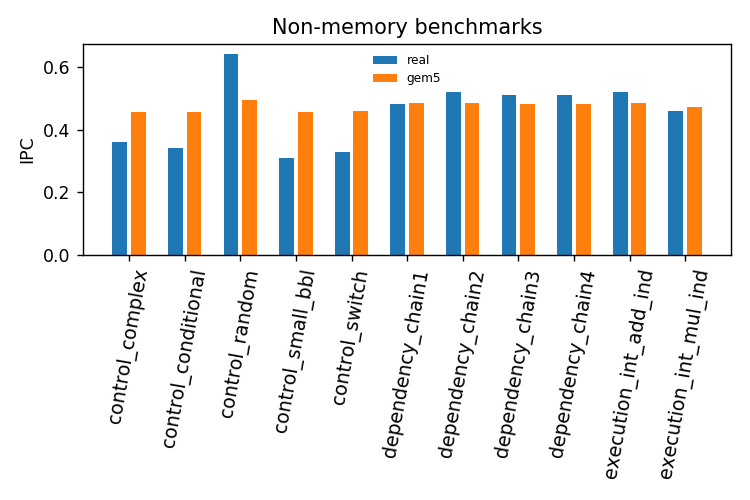

In [66]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4

plt.figure()

doplot_stat('ipc', 0)

plt.ylabel('IPC')
#plt.ylim(ymax=120)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=1, prop={'size': 7}, frameon=0)
plt.title('Non-memory benchmarks')
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")


<IPython.core.display.Javascript object>


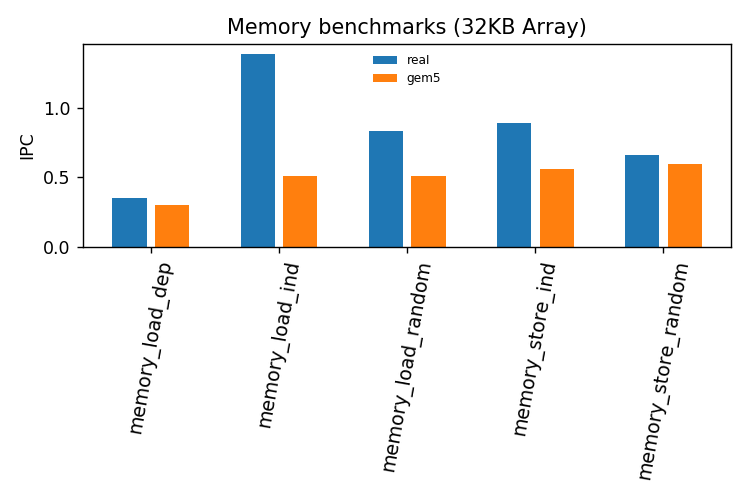

In [68]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4

plt.figure()

doplot_stat('ipc', '512')

plt.ylabel('IPC')
#plt.ylim(ymax=120)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=1, prop={'size': 7}, frameon=0)
plt.title('Memory benchmarks (32KB Array)')
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")


<IPython.core.display.Javascript object>


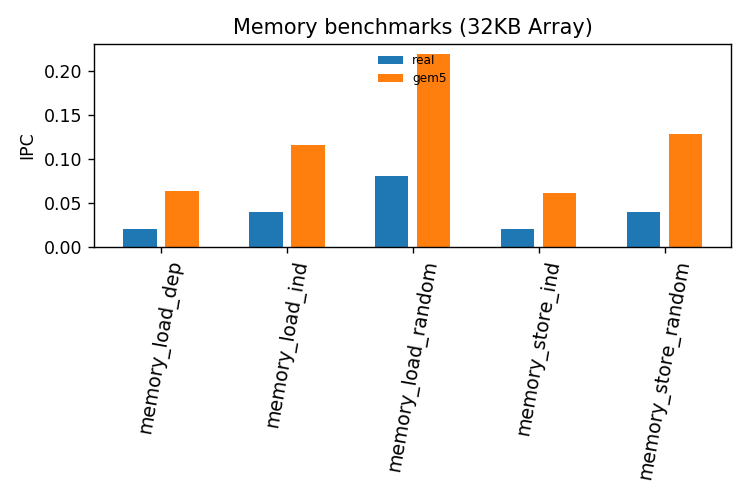

In [69]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4

plt.figure()

doplot_stat('ipc', '32768')

plt.ylabel('IPC')
#plt.ylim(ymax=120)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=1, prop={'size': 7}, frameon=0)
plt.title('Memory benchmarks (32KB Array)')
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

In [84]:
def doplot_mem(stat, bench, norm=False):   
    i = 0
    
    real = []
    gem5 = []
    
    for j,conf in enumerate(Configs):
        for s,size in enumerate(Sizes):
            #print(bench)    
            d = df[(df['benchmark']==bench) & (df['conf']==conf) & (df['size']==size)]
            
            if conf == 'real':
                real.append(float(d[stat].iloc[0]))
            else:
                gem5.append(float(d[stat].iloc[0]))

    
    plt.plot(Sizes, real, marker='x', color='C'+str(0), linewidth=1.3, markersize=3)
    plt.plot(Sizes, gem5, marker='o', color='C'+str(1), linewidth=1.3, markersize=3)
    
    for i,pfrm in enumerate(['real', 'gem5']):
        plt.bar(0,0,color='C'+str(i), label=pfrm)
    #plt.xticks((np.arange(len(bench_2_use))*3)+0.5, bench_2_use, rotation=80, ha='center',fontsize=11)

<IPython.core.display.Javascript object>


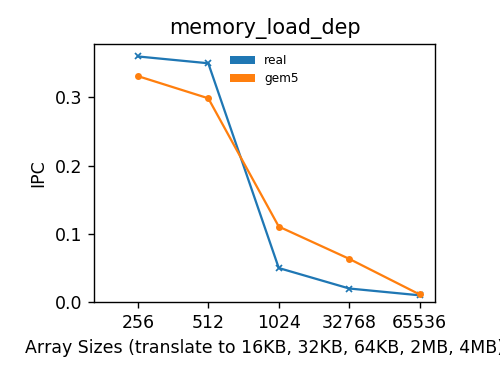

In [85]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 4
fig_size[1] = 3

plt.figure()

doplot_mem('ipc', 'memory_load_dep')

plt.ylabel('IPC')
plt.xlabel('Array Sizes (translate to 16KB, 32KB, 64KB, 2MB, 4MB)')
#plt.ylim(ymax=120)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=1, prop={'size': 7}, frameon=0)
plt.title('memory_load_dep')
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


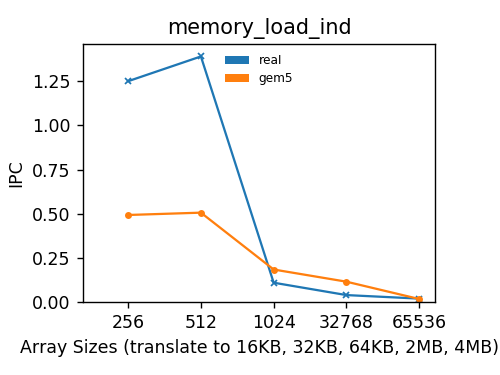

In [86]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 4
fig_size[1] = 3

plt.figure()

doplot_mem('ipc', 'memory_load_ind')

plt.ylabel('IPC')
plt.xlabel('Array Sizes (translate to 16KB, 32KB, 64KB, 2MB, 4MB)')
#plt.ylim(ymax=120)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=1, prop={'size': 7}, frameon=0)
plt.title('memory_load_ind')
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


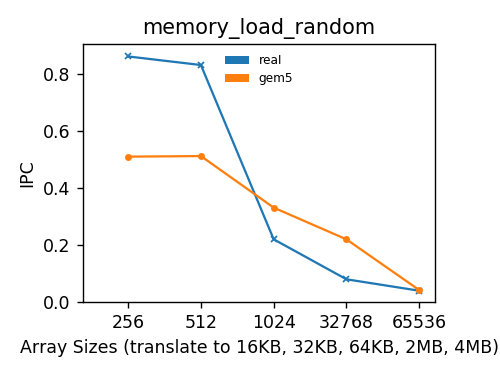

In [87]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 4
fig_size[1] = 3

plt.figure()

doplot_mem('ipc', 'memory_load_random')

plt.ylabel('IPC')
plt.xlabel('Array Sizes (translate to 16KB, 32KB, 64KB, 2MB, 4MB)')
#plt.ylim(ymax=120)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=1, prop={'size': 7}, frameon=0)
plt.title('memory_load_random')
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


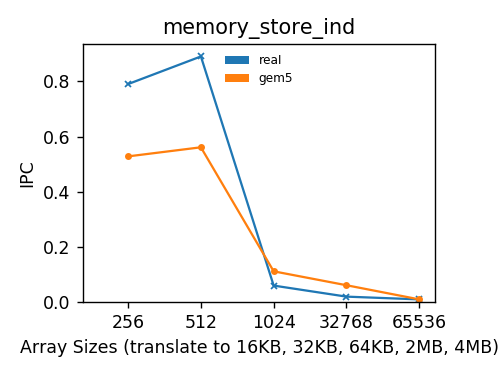

In [88]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 4
fig_size[1] = 3

plt.figure()

doplot_mem('ipc', 'memory_store_ind')

plt.ylabel('IPC')
plt.xlabel('Array Sizes (translate to 16KB, 32KB, 64KB, 2MB, 4MB)')
#plt.ylim(ymax=120)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=1, prop={'size': 7}, frameon=0)
plt.title('memory_store_ind')
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")